# JuliaCon - MMM Demo

Example application of Media Mix Modelling to optimize marketing spend

High-level workflow:
- Input and transform data
    - Provide column names of the corresponding to groups of variables (eg, `cols_spend` for Adspend variables to be modelled)
    - Variables that can have positive-only effects will be standardized to 0-1 range
    - Variables with any-signed effects will be at least standardized via Z-Score
- Set priors / conversion factors
    - Ie, use your domain knowledge to set realistic marketing transforms' parameters
- Stage 1: Fit the trend
    - Extract separate series for growth trend, seasonality, holidays, organic variables
- Stage 2: Fit the coefficients for marketing transformation
    - Validate the fit (Rhat, traceplots, etc)
- Quantify the contributions + ROAS of the current marketing spend
- Optimize the marketing budget to maximize the marketing contribution
    - Define a loss function that reflects your business' decision-making process
    - Evaluate the results of the optimization + inherent uncertainty

For more details on the methodology and practical tips visit [MMM Demo Docs](https://svilupp.github.io/JuliaCon2022/dev/)

In [ ]:
using Pkg; Pkg.activate(".");

import Optim
import Metaheuristics

using Logging
#### Optional: disable logging
# disable_logging(Logging.Info);
import DisplayAs

using MediaMixModellingDemo
# MMMDemo reexports: Turing,DataFramesMeta,Distributions,TableTransforms,Plots,StatsPlots

# Optional for better display:
ENV["LINES"]=200
ENV["COLUMNS"]=600
Threads.nthreads();

## Generate

Let's generate some example data where we know "truth", so we can test this implementation

You can see the "truth" if you have logging enabled for level INFO

[ Info: INDEX with 105 observations generated (random seed=0)
[ Info: TREND: Trend offset of 0.4 / Total growth of 0.2
[ Info: SEASONALITY: Series with periods 4 generated
┌ Info: HOLIDAYS: Number of days: 5
│  Average effect: -0.2
└  Total effect: -1.1
[ Info: EVENTS: 0 events generated with coefficients: 0
┌ Info: Marketing Variables: 
│ (label = "facebook_S", mean = 0.4, std = 0.2, sparsity = 1.0, decay_rate = 0.5, halfpoint = 0.4, slope = 1.5, unit_scale_ratio = 0.05, coef = 2.0) |
│  (label = "tv_S", mean = 0.8, std = 0.2, sparsity = 0.7, decay_rate = 0.8, halfpoint = 0.8, slope = 0.9, unit_scale_ratio = 0.1, coef = 1.3) |
│  (label = "search_S", mean = 0.5, std = 0.3, sparsity = 1.0, decay_rate = 0.05, halfpoint = 0.5, slope = 2.0, unit_scale_ratio = 0.05, coef = 2.5)
└ ROAS: facebook_S: 2.0 | tv_S: 1.3 | search_S: 2.5
[ Info: CONTEXT: Number of vars: 3 Coefs: 0.1,0.0,-0.1
[ Info: NOISE: Noise scale of 0.1 (compared to Y STD of 0.2)
┌ Info: Total Rev: 101.9
└  Per-Period Rev AVG:

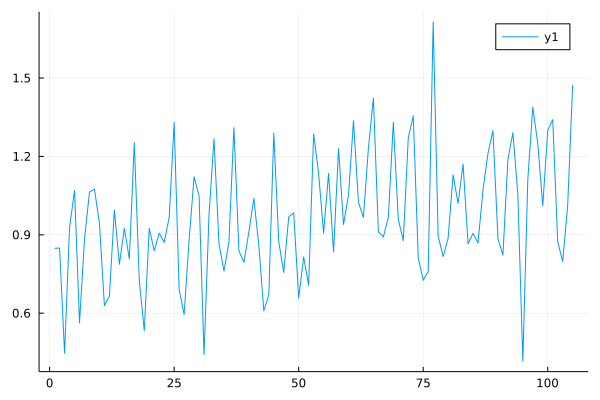

In [2]:
Y,X,col_names=create_dataset("2020-02-01",105,0);

# Let's apply standard notation of df being the source of data
df=X
df[!,:revenue]=vec(sum.(eachrow(Y)));

img=plot(df.revenue)
img=DisplayAs.PNG(img) # trick for Literate.jl

# Modelling

We will fit the model in 2 stages to deal with the under-specification.

As a convention the deterministic location of the observed variable (mean of the RV `y`) will be called `mu` and its components will be all prefixed as such, eg,
- `mu_trend` for the trend component,
- `mu_seas` for the seasonality component,
- `mu_hols` for the holidays component,
- `mu_context` for the contributions of the contextual variables,
- `mu_org`
- `mu_spend` for the contribution of all Ad spend variables together
- `mu_spend_by_var` for the contributions of each individual spend variables (ie, number of columns = number of Ad spend variables)

(See `src/model_definition.jl` for more details)

All these deterministic components will be exposed by DynamicPPL in the return statement to be easily extracted via `generated_quantities()` conditioned on fitted samples (a `chains` object). In other words, given a model fit, we can easily extract all the above components by playing the samples through the model.

Let's choose what model implementation we want:

In [3]:
# Model used in stage1
const MODEL_NAME_PREFIT="model_stage1a"
model_func_stage1=getfield(MediaMixModellingDemo,Symbol(MODEL_NAME_PREFIT))

# Model used in stage2
const MODEL_NAME="model_stage2a"
model_func_stage2=getfield(MediaMixModellingDemo,Symbol(MODEL_NAME))

# Modifier of chart titles
const EXPERIMENT_NAME=" JuliaCon"
pplot=ParamsPlot(title_suffix=EXPERIMENT_NAME)
;

## Data

Let's identify seasonalities in our data (for trend modelling)

Pick the ones with the highest value (usually only 1 or 2 max)

#1 period: 4.0 with 10.0
#2 period: 105.0 with 5.3
#3 period: 35.0 with 3.7


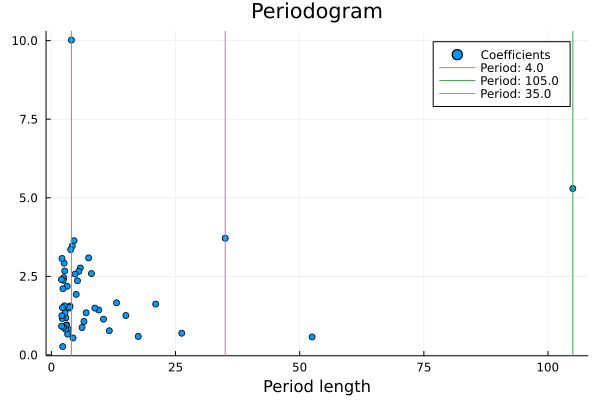

In [4]:
# what's the seasonality
img=plot_periodogram(df.revenue .- mean(df.revenue),3)
img=DisplayAs.PNG(img) # trick for Literate.jl

Let's build our input data object:

In [5]:
@doc build_inputs

```
build_inputs(df::AbstractDataFrame;
    cols_spend::AbstractVector{String},
    col_target::String="revenue",
    col_datetime::String="dt",
    col_time_std::String="time_std",
    col_cat::String="",
    cols_hols::AbstractVector{String}=String[],
    cols_context::AbstractVector{String}=String[],
    cols_organic::AbstractVector{String}=String[],
    seasonality_periods::AbstractVector{Float64}=Float64[],
    spline_degree::Int=0,
    fit_stage2_mask::AbstractVector{Bool}=trues(nrow(df)),
    optim_mask::AbstractVector{Bool}=trues(nrow(df))
)
```

Builds the input data object for the successing fitting & optimization

Arguments:

  * col_target::String="revenue" - column name of the target/response variable (eg, revenues)
  * col_datetime::String="dt" - column name of the variable with dates
  * col*time*std::String="time_std" - column name of the standardized time index (from 0-1, strict)
  * col_cat::String="events" - column name of the categorical variable representing various events (ie not available); Set to "" if there isn't any
  * cols_context::AbstractVector{String}=String[] - column name of the context variables (eg, macroeconomic indicators, market trends, competitors sales or promotions) (variables will be standardized via Z-score); Defaults to empty if there are none
  * cols_organic::AbstractVector{String}=String[] - column name of the organic marketing activities (eg, email newsletters) (variables will be scaled to maximum=1 via Max() function and their effect on response can be only positive); Defaults to empty if there are none
  * cols_hols::AbstractVector{String}=String[] - column name of the holiday indicators; Defaults to empty if there are none
  * cols_spend::AbstractVector{String} - column names of the Ad spend variables that we want to model (variables will be scaled to maximum=1 via Max() function)
  * seasonality_periods::AbstractVector{Float64}=Float64[] - what seasonalities are expected in the trendline; Defaults to empty if there are none
  * spline_degree::Int=0 - if complicated trend modelling is needed, what degree of spline basis should be used (uses cubic bases splines from Splines2.jl)
  * fit*stage2*mask::AbstractVector{Bool}=trues(nrow(df)) - mask to be apllied to observed data in Stage 2 of modelling (use the observation when `=true`); Defaults to all observations being used
  * optim_mask::AbstractVector{Bool}=trues(nrow(df)) - mask to be apllied in the budget optimization (use the observation when `=true`); Defaults to all observations being used


In [6]:
inputs=build_inputs(df;
    col_target="revenue",col_datetime="dt",col_time_std="time_std",col_cat="events",
    cols_context=[c for c in col_names.cols_context if c!="newsletters"],
    cols_organic=["newsletters"],
    cols_hols=["hols_ind"],
    cols_spend=col_names.cols_spend,
    seasonality_periods=[4.],
    spline_degree=0
);

┌ Info: Time index stats: 
│   time_std |> size = (105,)
└   time_std |> extrema = (0.0, 1.0)


## Stage 1 - Prophet-like model

Let's fit a model to the trend, seasonality and holidays

Note: We do not adstock/saturate the marketing spend at this stage

In [7]:
p1=set_priors(
    ParamsStage1(
        model_name=Val(Symbol(MODEL_NAME_PREFIT)),
        scales_trend=0.2,
        scales_hols=0.3,
        scales_noise=0.2,
        cat_levels=1
    ),
    inputs
);

┌ Info: Trendline:
│   scales_trend_offset = 0.45741119137901
└   scales_growth_trend = 1.737099382015156
[ Info: Key scales_seas: 0.20 | 0.14 | 0.20 | 0.20 | 10.00 | 0.20  Warnings: A variable hit maximum allowed scale! Set to 10.0!
[ Info: Key scales_feat: 0.67 | 0.36 | 0.53 | 0.49 | 0.14 | 0.14


### Fit

In [8]:
stage1fit=fit(inputs,p1,model_func_stage1,NUTS(300,0.65;max_depth=10));

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fnRmh/src/sample.jl:291
Sampling (1 threads)   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |  ETA: N/A
┌ Info: Found initial step size
└   ϵ = 0.2
Sampling (1 threads) 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [9]:
# Optional: Check the priors used and if they are sensible
# y_prior=mapreduce(x->rand(stage1fit.model).y,hcat,1:100)|>vec
# plot_prior_predictive_histogram(inputs.y_std,y_prior,ParamsPlot())

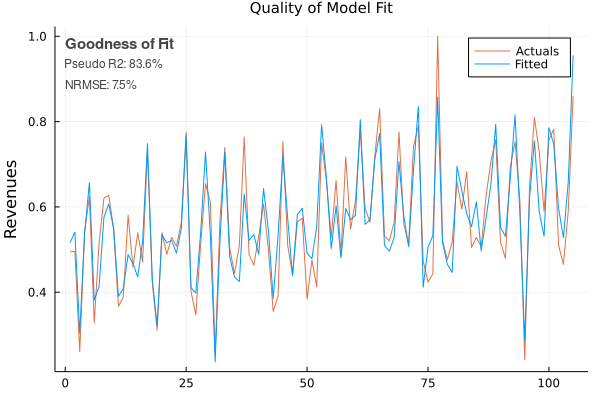

In [10]:
img=plot_model_fit_by_period(inputs.y_std,predict(stage1fit),ParamsPlot())
img=DisplayAs.PNG(img) # trick for Literate.jl

## Stage 2 - Fit the Marketing Drivers

Let's use the fit from the first stage and focus mostly on the marketing variables (including their adstock/saturation transformations)

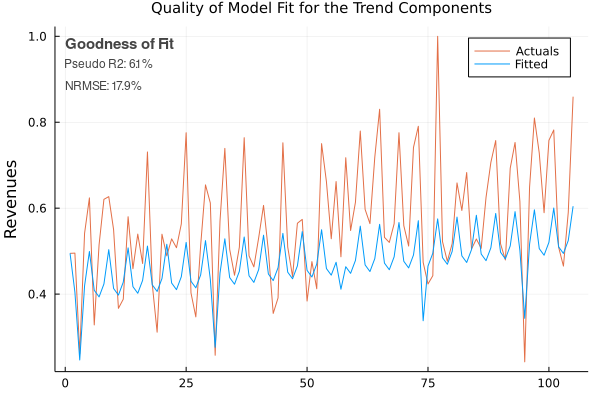

In [11]:
img=plot_model_fit_by_period(inputs.y_std,sum(stage1fit.stage1_fitted_trends,dims=2)|>vec,
    ParamsPlot(title_suffix=" for the Trend Components"))
img=DisplayAs.PNG(img) # trick for Literate.jl

### Fit

[ Info: Key scales_context: 0.14 | 0.14
[ Info: Key scales_org: 0.49
┌ Info: Hill Curve: 
│ adspend_mean_nonzero: 0.49 | 0.75 | 0.50
│ adspend_median: 0.45 | 0.58 | 0.47
│ locs_spend_halfmaxpoint: 0.49 | 0.75 | 0.50
│ scales_spend_halfmaxpoint: 0.30 | 0.30 | 0.30
│ locs_spend_beta: 1.00 | 1.00 | 1.00
│ scales_spend_beta: 1.50 | 1.50 | 1.50
│ units_ratio_spend_to_y: 0.02 | 0.06 | 0.03
└ factor_to_roas_of_one: 0.05 | 0.12 | 0.06
┌ Info: Decay Rates: 
│ facebook_S: Mean 0.09 | Range 0.01-0.26 | Halflife 0.29 periods
│ tv_S: Mean 0.56 | Range 0.43-0.67 | Halflife 1.18 periods
└ search_S: Mean 0.09 | Range 0.01-0.26 | Halflife 0.29 periods


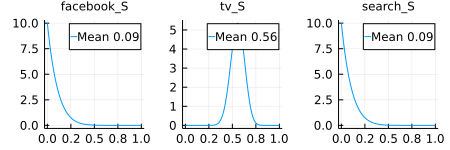

In [12]:
p2=set_priors(
    ParamsStage2(
        model_name=Val(Symbol(MODEL_NAME)),
        scales_trend_offset=0.3,
        scales_trend=0.2,
        scales_noise=0.3,
    ),
    inputs
);
# quick check of decay_rate priors
p2 = set_priors_stage2_decay_rates(["digital","tv","digital"],decay_rates_types_dictionary,
    p2,inputs.cols_spend)

# let's check if our priors make sense given te data
sanity_check_priors(p2;inputs.X_spend,inputs.X_context,inputs.X_org);

# let's visualize the selected decay rates
img=plot_priors_decay_rate(p2,inputs.cols_spend)
img=DisplayAs.PNG(img) # trick for Literate.jl

In [13]:
stage2fit=fit(inputs,stage1fit,p2,model_func_stage2,
    NUTS(300,0.65;max_depth=10);
    mcmc_samples=250,mcmc_chains=4);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fnRmh/src/sample.jl:291
Sampling (1 threads)   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |  ETA: N/A
┌ Info: Found initial step size
└   ϵ = 0.0125
┌ Info: Found initial step size
└   ϵ = 0.2
Sampling (1 threads)  25%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  

In [14]:
# Optional1: Check the priors used and if they are sensible
# y_prior=mapreduce(x->rand(stage1fit.model).y,hcat,1:100)|>vec
# plot_prior_predictive_histogram(inputs.y_std,y_prior,ParamsPlot())

## Optional2: Show the posterior samples of quantities of interest
# stage2fit.chain

## Optional3: Diagnostics if the parameter space has been properly explored
# corner(chain[[namesingroup(stage2fit.chain,"slope")...,
#             namesingroup(stage2fit.chain,"decay_rate")...]],
#     guidefontsize=8,size=(1000,1000))

# corner(chain[[namesingroup(chain,"slope")...,
# namesingroup(chain,"beta_spend")...,Symbol("beta_org[1]")]],
#     guidefontsize=8,size=(1000,1000))

# Optional4: Diagnostics of the mixing in the chains
# Display traceplots -- look for "fuzzy caterpillars"! Any flat lines (ie, chain getting stuck on some values) indicate problems!
# plot(chain)

## Evaluation

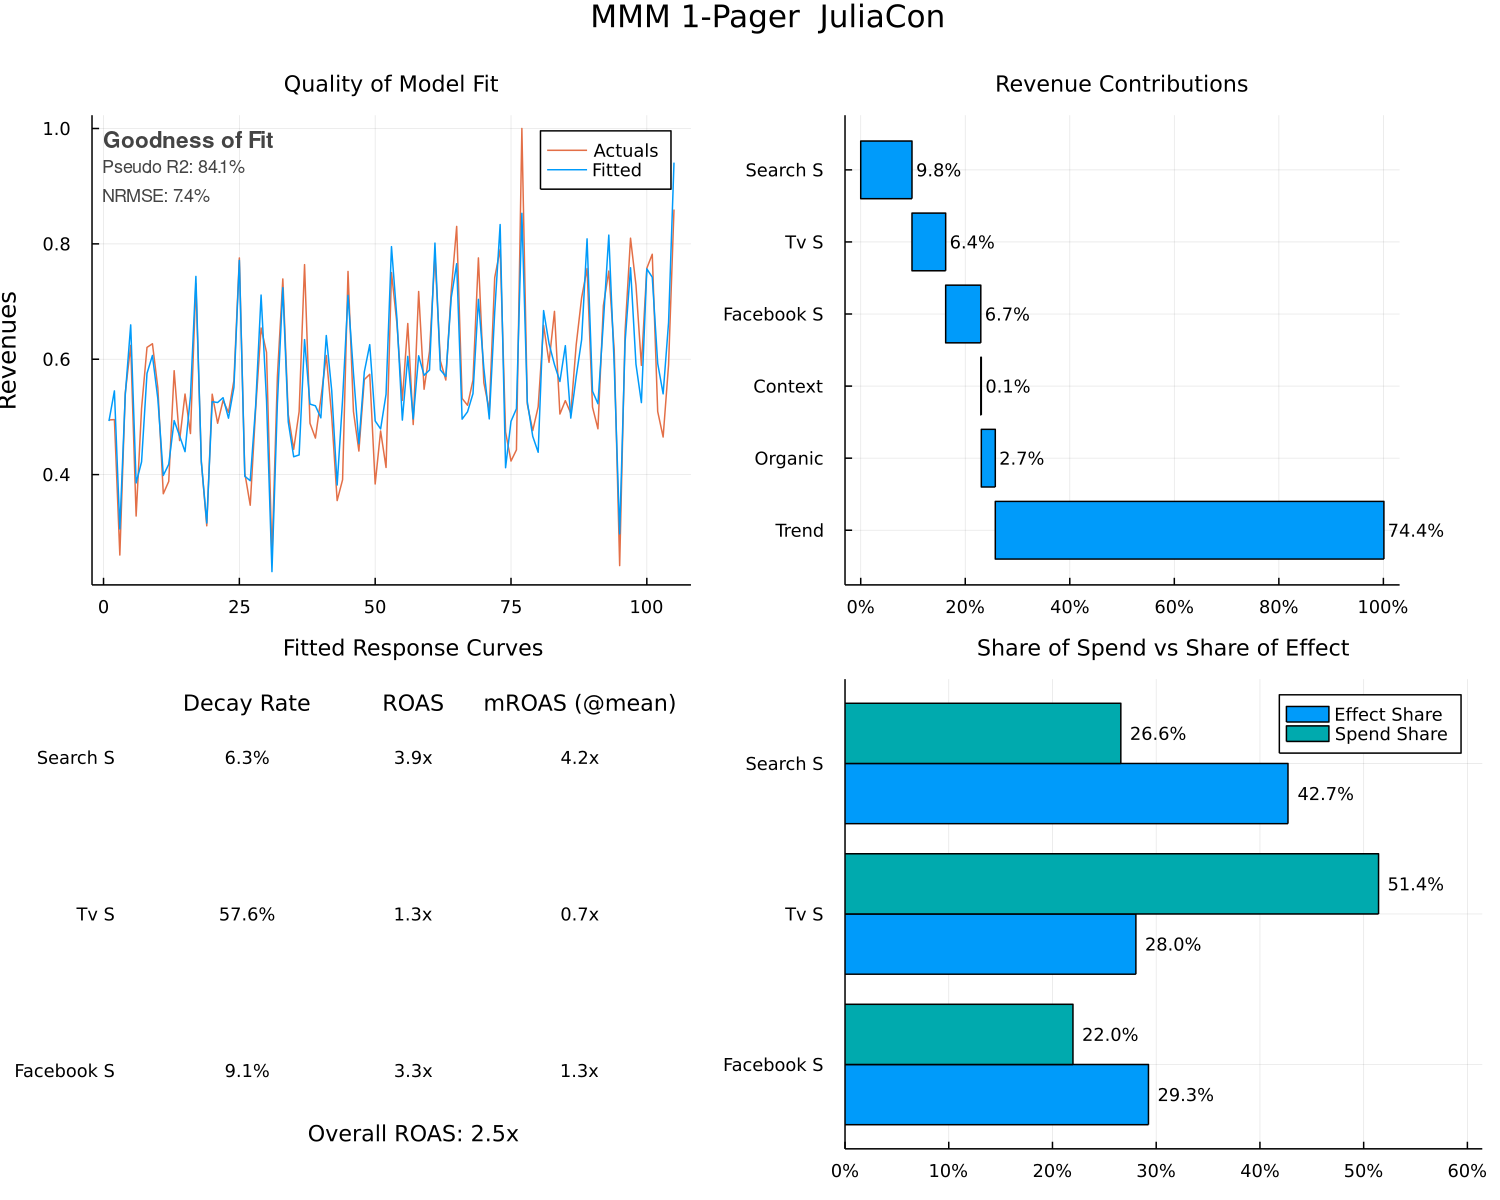

In [15]:
img=plot(stage2fit,inputs,pplot)
img=DisplayAs.PNG(img) # trick for Literate.jl
#### optional: save the chart
# savefig(pl,joinpath(pwd(),"exports","mmm-1pager-$(pplot.title_suffix).png"))

# Optimization

Let's optimize the marketing budget, ie, let's find out by what factor should we increase/decrease our spend on each marketing channel/activity without spending more money overall

## Metaheuristics loop

In [16]:
###### Metaheuristics Options (runs ECA algorithm under the hood)
# time_limit is in seconds
# debug = true if you want to see each iteration
# parallel_evaluation = true if you have batch-enabled objective function (see docs for `threaded_objective_func`)
metaheuristics_options = Metaheuristics.Options(time_limit=60.,debug=false,parallel_evaluation=true)
optimalbudget=optimize(stage2fit,inputs;metaheuristics_options);

# quick sanity check
sanity_check_optimum(optimalbudget,stage2fit,inputs);

┌ Info: +=========== RESULT ==========+
│   iteration: 9
│     minimum: -0.934309
│   minimizer: [1.2898187510636208, 0.6230113507285323, 1.4890097024930258]
│     f calls: 378
│   feasibles: 42 / 42 in final population
│  total time: 60.1242 s
│ stop reason: Maximum time exceeded.
└ +============================+


## 1-Pager

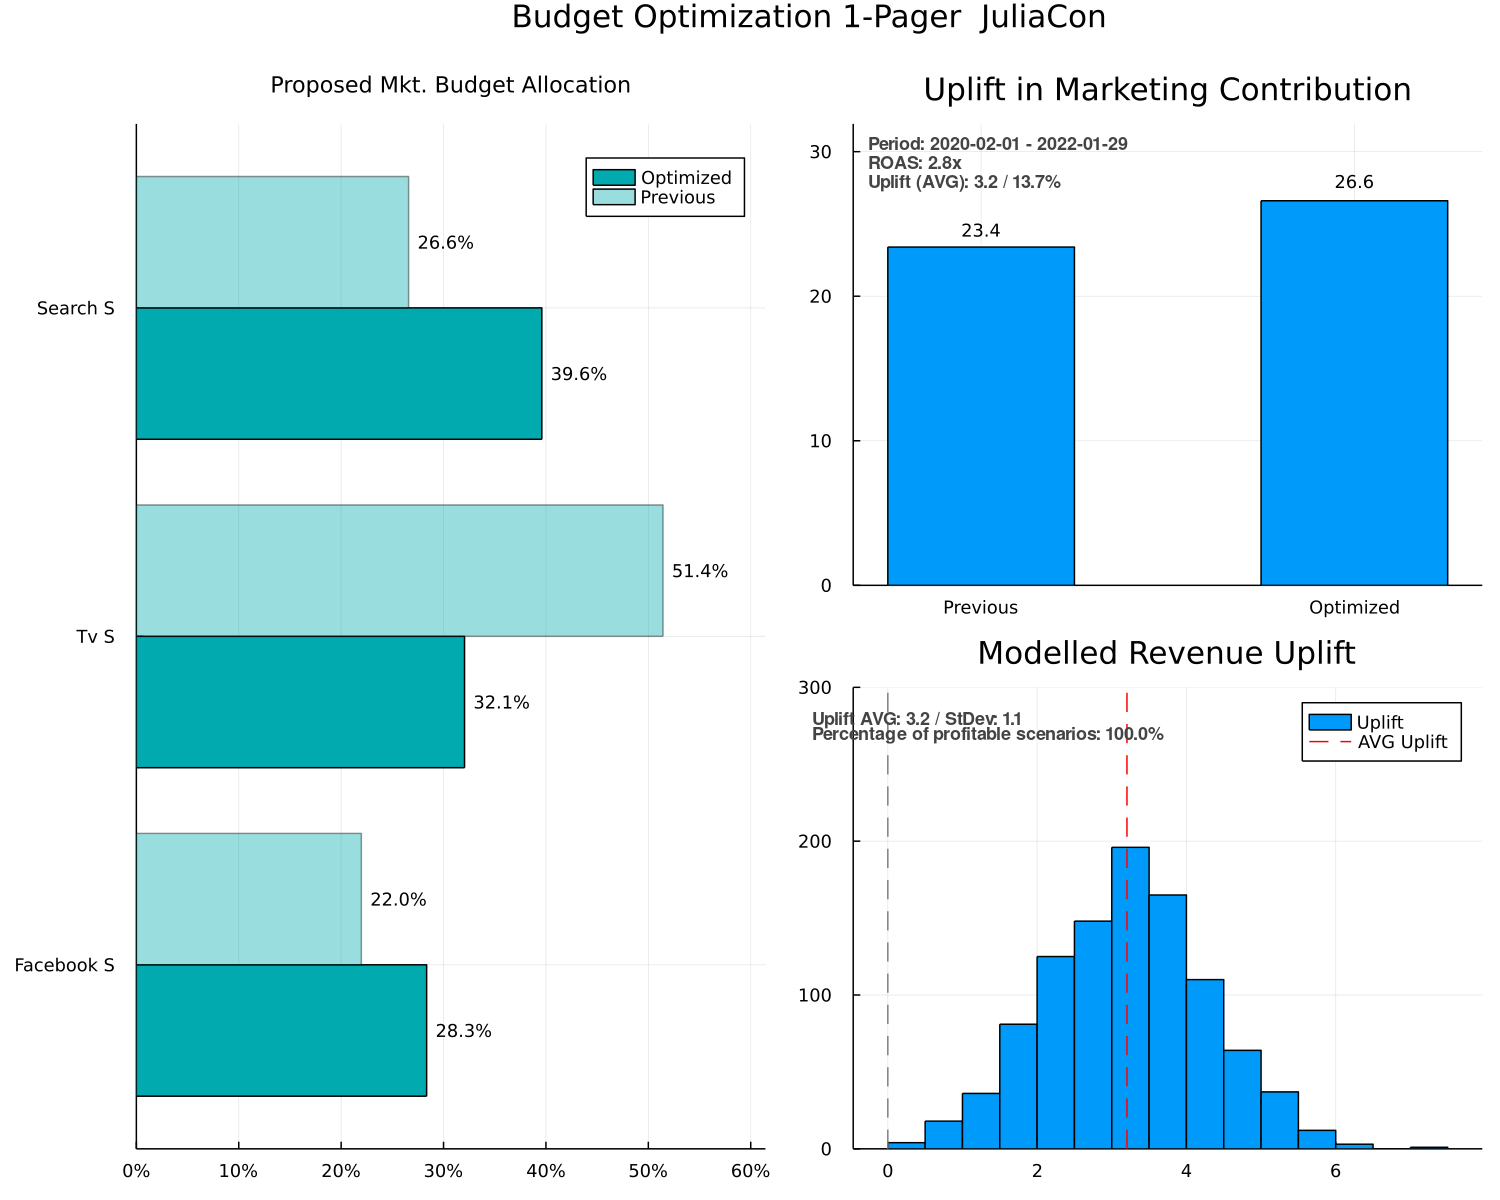

In [17]:
img=plot(optimalbudget,stage2fit,inputs,pplot)
img=DisplayAs.PNG(img) # trick for Literate.jl
#### optional: save the chart
# savefig(pl,joinpath(pwd(),"exports","optimization-1pager-$(pplot.title_suffix).png"))

# END

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*